### Visual Explanation Example

In [ ]:
#generate heatmap for given image.
#If you want to generate heatmap for other image, change IMAGE_PATH

import torch
import torchvision.transforms as transforms
import numpy as np
import PIL
import matplotlib.pyplot as plt
from Datasets.ILSVRC_classes import classes
import torch.utils.model_zoo as model_zoo

#models
import Methods.AGCAM.ViT_for_AGCAM as ViT_Ours
import timm
from Methods.LRP.ViT_LRP import vit_base_patch16_224 as LRP_vit_base_patch16_224

#methods
from Methods.AGCAM.AGCAM import AGCAM
from Methods.LRP.ViT_explanation_generator import LRP
from Methods.AttentionRollout.AttentionRollout import VITAttentionRollout

MODEL = 'vit_base_patch16_224'
IMG_SIZE=224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/ILSVRC2012_val_00000125.jpeg"


# Load the model parameter provided by the Timm library
state_dict = model_zoo.load_url('https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth', progress=False, map_location=device)

# Image transformation for ImageNet ILSVRC 2012.
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# For convert the input image into original distribution to display
unnormalize = transforms.Compose([
    transforms.Normalize([0., 0., 0.], [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize([-0.5, -0.5, -0.5], [1., 1., 1.,])
])


# Open the input image and transform
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)

class_num=1000

# Models and Methods
ours_model = ViT_Ours.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
ours_model.load_state_dict(state_dict, strict=True)
ours_model.eval()
ours_method = AGCAM(ours_model)
lrp_model = LRP_vit_base_patch16_224(device, num_classes=class_num).to(device)
lrp_model.load_state_dict(state_dict, strict=True)
lrp_model.eval()
lrp_method = LRP(lrp_model, device)
rollout_model = timm.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
rollout_model.load_state_dict(state_dict, strict=True)
rollout_model.eval()
rollout_method = VITAttentionRollout(rollout_model, device=device)




with torch.enable_grad():
    # Generate heatmap of our method
    prediction, ours_heatmap = ours_method.generate(image)
    ours_heatmap = transforms.Resize((224, 224))(ours_heatmap[0])
    ours_heatmap = (ours_heatmap - ours_heatmap.min())/(ours_heatmap.max()-ours_heatmap.min())
    ours_heatmap = ours_heatmap.detach().cpu().numpy()
    ours_heatmap = np.transpose(ours_heatmap, (1, 2, 0))

    # Generate heatmap of LRP-based method
    _, lrp_heatmap = lrp_method.generate(image)
    lrp_heatmap = transforms.Resize((224, 224))(lrp_heatmap[0])
    lrp_heatmap = (lrp_heatmap - lrp_heatmap.min())/(lrp_heatmap.max()-lrp_heatmap.min())
    lrp_heatmap = lrp_heatmap.detach().cpu().numpy()
    lrp_heatmap = np.transpose(lrp_heatmap, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))


    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1,4, figsize=(15, 70))
    axs[0].set_title(classes[prediction.item()])
    axs[0].imshow(image)
    axs[0].axis('off')
    
    axs[1].set_title('Ours')
    axs[1].imshow(image)
    axs[1].imshow(ours_heatmap, cmap='jet', alpha=0.5)
    axs[1].axis('off')
    
    axs[2].set_title('LRP-based')
    axs[2].imshow(image)
    axs[2].imshow(lrp_heatmap, cmap='jet', alpha=0.5)
    axs[2].axis('off')

    axs[3].set_title('Attention Rollout')
    axs[3].imshow(image)
    axs[3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[3].axis('off')
    

c:\Users\Asus\miniconda3\envs\cuda_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input image shape after transform: torch.Size([3, 224, 224])
Input image shape after unsqueeze: torch.Size([1, 3, 224, 224])
Masks resutl: torch.Size([12, 12, 1, 197])
my mask: torch.Size([12, 12, 1, 14, 14])
torch.Size([1, 12, 12, 1, 196])
torch.Size([1, 12, 12, 1, 14, 14])
mask shape before transpose: (1, 224, 224)
mask shape for visualize: (224, 224, 1)
Mask value: [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
tensor img: torch.Size([3, 224, 224])
tensor mask: torch.Size([1, 1, 224, 224])
output: torch.Size([1, 1000])
prediction found: tensor([126], device='cuda:0')
mask shape before transpose: (1, 224, 224)
mask shape for visualize: (224, 224, 1)
Mask value: [[[0.00725196]
  [0.00725196]
  [0.00725196]
  ...
  [0.00268124]
  [

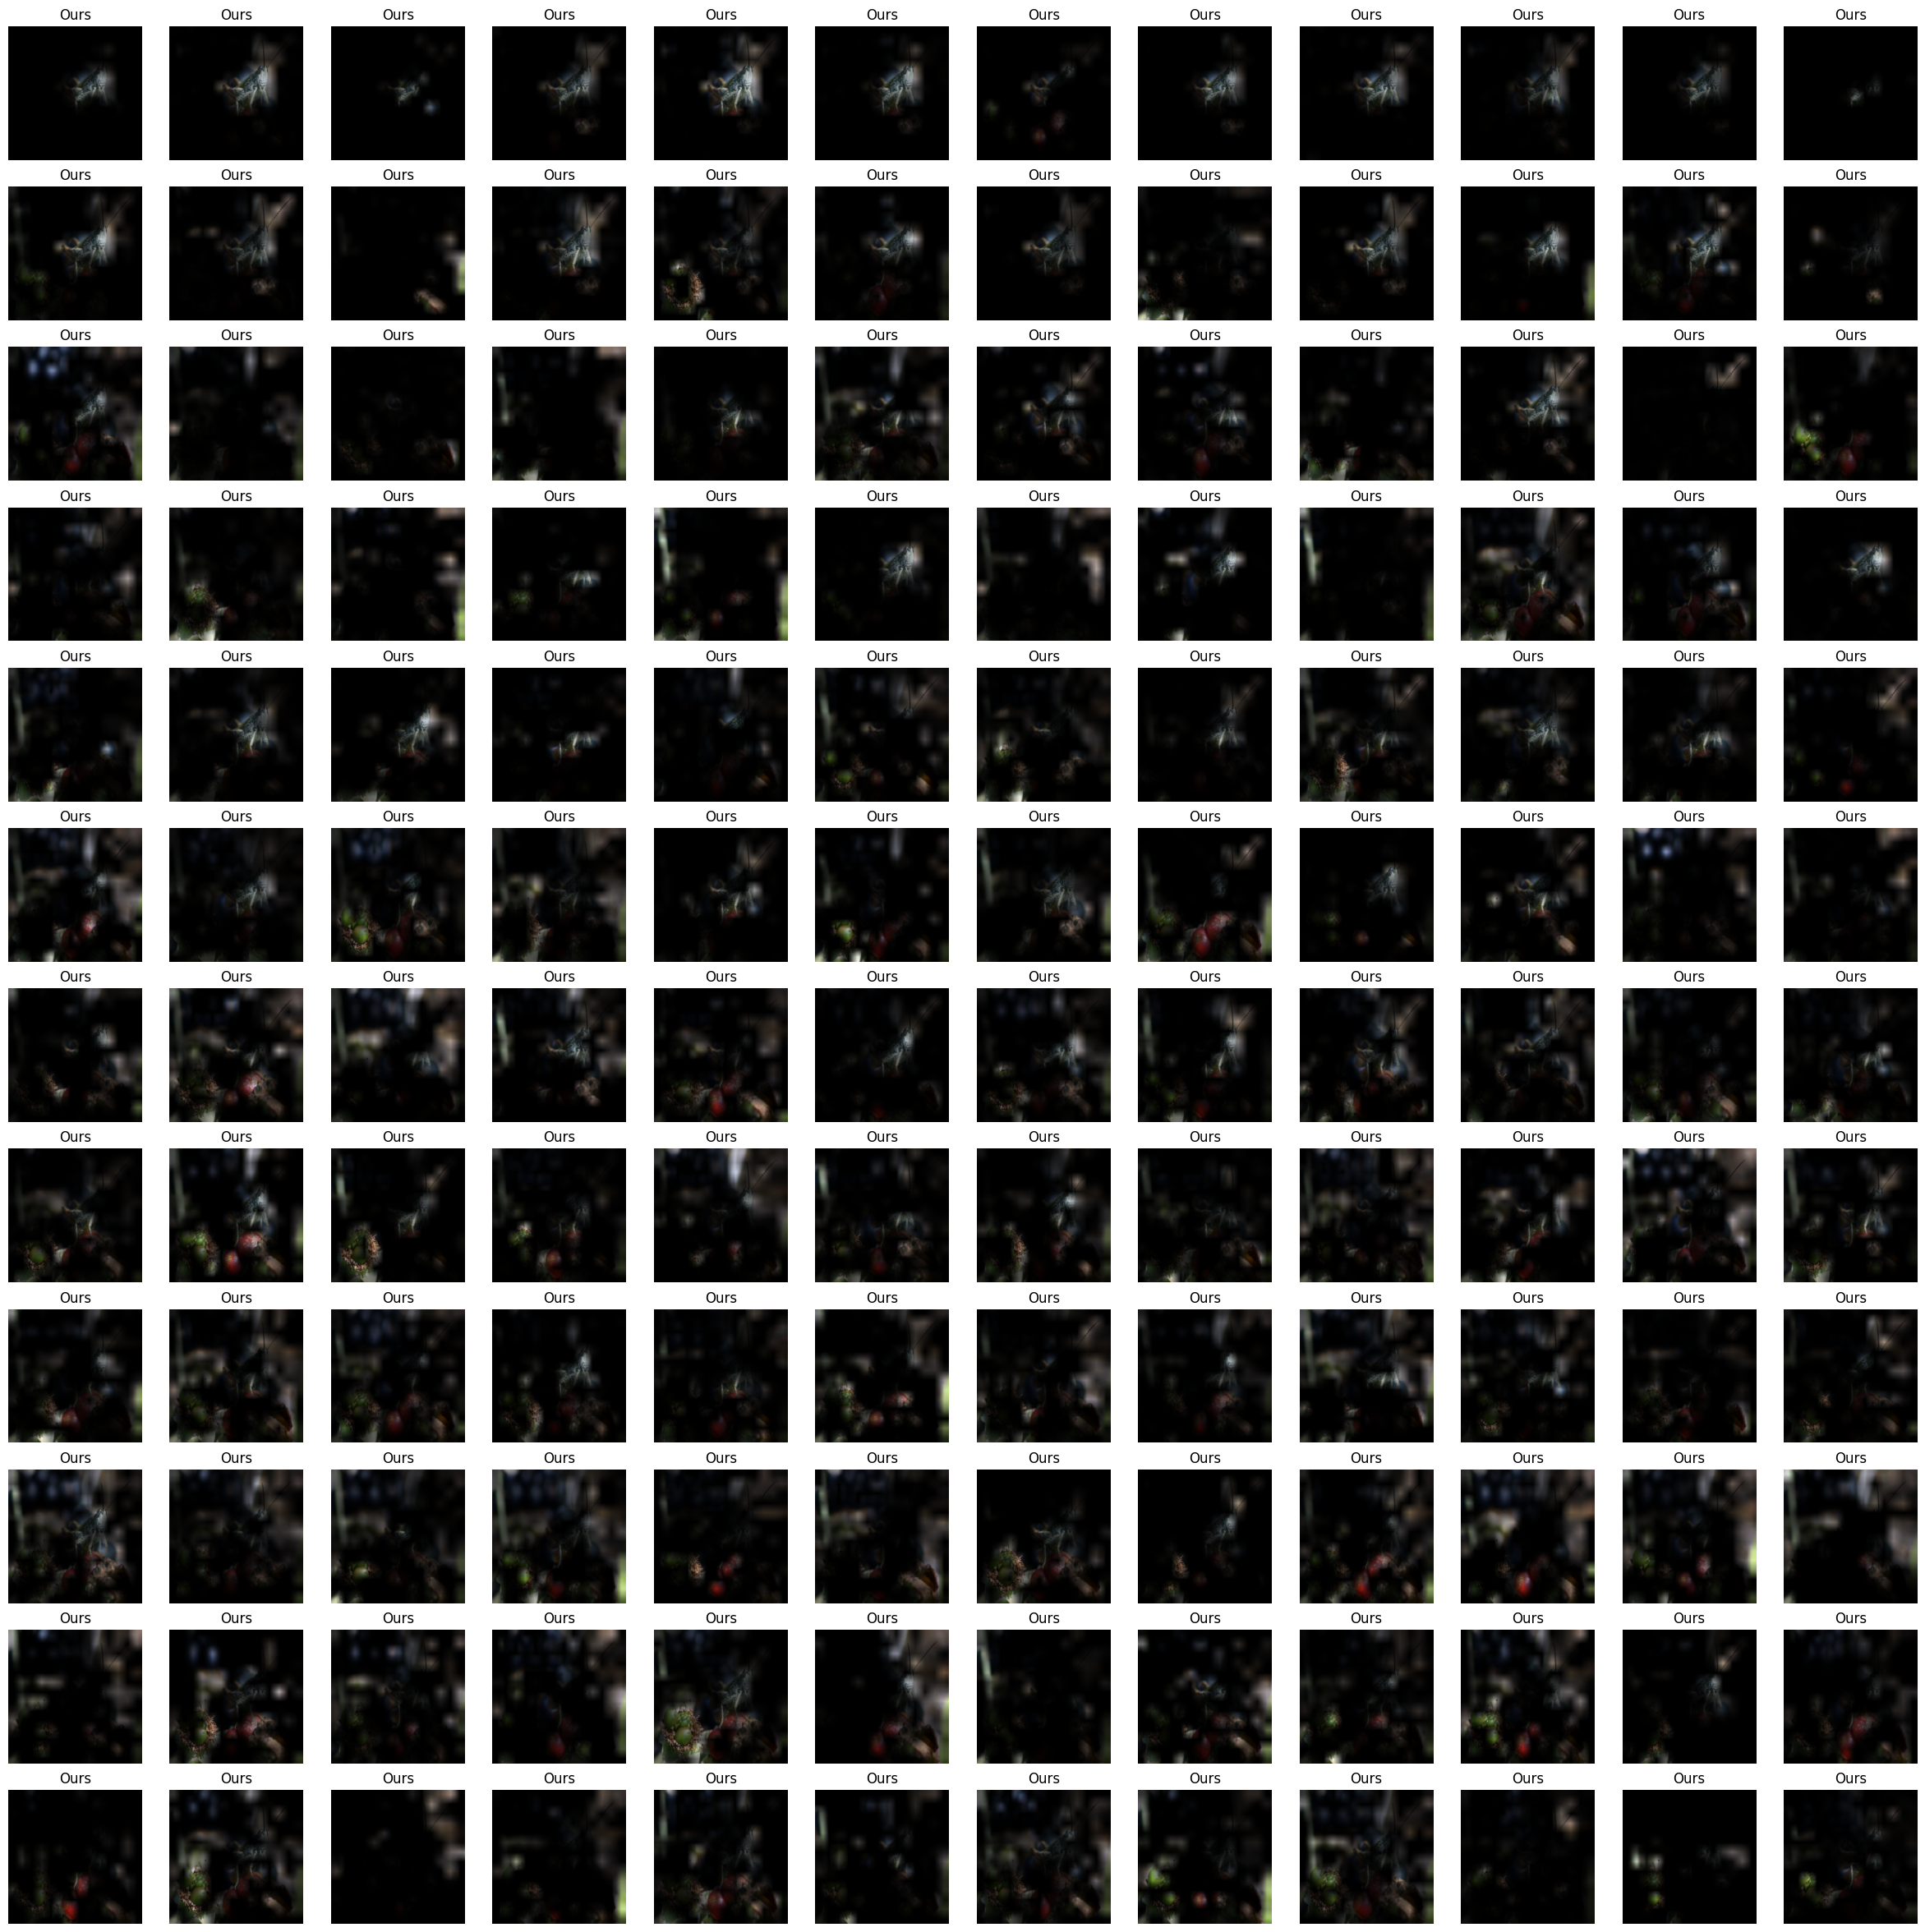

In [1]:
#generate heatmap for given image.
#If you want to generate heatmap for other image, change IMAGE_PATH

import torch
import torchvision.transforms as transforms
import numpy as np
import PIL
import matplotlib.pyplot as plt
from Datasets.ILSVRC_classes import classes
import torch.utils.model_zoo as model_zoo

#modelsa
import Methods.AGCAM.ViT_for_AGCAM as ViT_Ours
import timm
from Methods.LRP.ViT_LRP import vit_base_patch16_224 as LRP_vit_base_patch16_224

#methods
from Methods.AGCAM.AGCAM import AGCAM
from Methods.LRP.ViT_explanation_generator import LRP
from Methods.AttentionRollout.AttentionRollout import VITAttentionRollout

MODEL = 'vit_base_patch16_224'
IMG_SIZE=224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/ILSVRC2012_val_00000125.jpeg"


# Load the model parameter provided by the Timm library
state_dict = model_zoo.load_url('https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth', progress=False, map_location=device)

# Image transformation for ImageNet ILSVRC 2012.
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# For convert the input image into original distribution to display
unnormalize = transforms.Compose([
    transforms.Normalize([0., 0., 0.], [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize([-0.5, -0.5, -0.5], [1., 1., 1.,])
])


# Open the input image and transform
image = PIL.Image.open(IMAGE_PATH)
# print(f'Input image shape before transformer: {image.shape}')
image = transform(image)
squeezed_img = image
print(f'Input image shape after transform: {image.shape}')
image = image.unsqueeze(0).to(device)
print(f'Input image shape after unsqueeze: {image.shape}')


class_num=1000

# Models and Methods
ours_model = ViT_Ours.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
ours_model.load_state_dict(state_dict, strict=True)
ours_model.eval()
ours_method = AGCAM(ours_model)
lrp_model = LRP_vit_base_patch16_224(device, num_classes=class_num).to(device)
lrp_model.load_state_dict(state_dict, strict=True)
lrp_model.eval()
lrp_method = LRP(lrp_model, device)
rollout_model = timm.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
rollout_model.load_state_dict(state_dict, strict=True)
rollout_model.eval()
rollout_method = VITAttentionRollout(rollout_model, device=device)




with torch.enable_grad():
    # Generate heatmap of our method
    prediction, ours_heatmap, _ = ours_method.generate(image, 311)

    fig, axs = plt.subplots(12,12, figsize=(30, 30))
    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    # axs[0].set_title(classes[prediction.item()])
    # axs[0].imshow(image)
    # axs[0].axis('off')

    cur_index = 0
    for i in range(ours_heatmap.size(1)):     # Loop over the first dimension (12)
        for j in range(ours_heatmap.size(2)): # Loop over the second dimension (12)
            heatmap = transforms.Resize((224, 224))(ours_heatmap[0][i][j])

            heatmap = (heatmap - heatmap.min())/(heatmap.max()-heatmap.min())
            tensor_heatmap = heatmap
            heatmap = heatmap.detach().cpu().numpy()
            print(f'mask shape before transpose: {heatmap.shape}')
            heatmap = np.transpose(heatmap, (1, 2, 0))
            print(f'mask shape for visualize: {heatmap.shape}')
            print(f'Mask value: {heatmap}')
    # # Generate heatmap of LRP-based method
    # _, lrp_heatmap = lrp_method.generate(image)
    # lrp_heatmap = transforms.Resize((224, 224))(lrp_heatmap[0])
    # lrp_heatmap = (lrp_heatmap - lrp_heatmap.min())/(lrp_heatmap.max()-lrp_heatmap.min())
    # lrp_heatmap = lrp_heatmap.detach().cpu().numpy()
    # lrp_heatmap = np.transpose(lrp_heatmap, (1, 2, 0))

    # # Generate heatmap of Attention Rollout
    # _, rollout_heatmap = rollout_method.generate(image)
    # rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    # rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    # rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    # rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))

            axs[i][j].set_title('Ours')
            # axs[i][j].imshow(image)
            # axs[i][j].imshow(heatmap, cmap='jet', alpha=1)
            # print(f'image shape: {image.shape}')
            # print(f'mask shape: {heatmap.shape}')
            axs[i][j].imshow(image*heatmap, alpha=1, cmap='jet')
            axs[i][j].axis('off')

            tensor_img = squeezed_img.unsqueeze(0).to(device)
            print(f'tensor img: {squeezed_img.shape}')
            
            tensor_heatmap = tensor_heatmap.unsqueeze(0).to(device)
            print(f'tensor mask: {tensor_heatmap.shape}')

            m = tensor_img * tensor_heatmap
            ours_model.zero_grad()
            output = ours_model(m)
            print(f'output: {output.shape}')
            _, prediction = torch.max(output, 1)
            print(f'prediction found: {prediction}')
            
            # mask
            # image = PIL.Image.open(IMAGE_PATH)
            # image = transform(image)
            # image = image.unsqueeze(0).to(device)
            # heatmap = transform(heatmap)
            # heatmap = heatmap.unsqueeze(0).to(device)
            # m = image * heatmap
            # # Feed to network to get logit of target class
            # logit = ours_model(m)
            # print(logit)
    
    # axs[2].set_title('LRP-based')
    # axs[2].imshow(image)
    # axs[2].imshow(lrp_heatmap, cmap='jet', alpha=0.5)
    # axs[2].axis('off')

    # axs[3].set_title('Attention Rollout')
    # axs[3].imshow(image)
    # axs[3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    # axs[3].axis('off')
    



# Quậy phá time

In [1]:
#generate heatmap for given image.
#If you want to generate heatmap for other image, change IMAGE_PATH

import torch
import torchvision.transforms as transforms
import numpy as np
import PIL
import matplotlib.pyplot as plt
from Datasets.ILSVRC_classes import classes
import torch.utils.model_zoo as model_zoo

#modelsa
import Methods.AGCAM.ViT_for_AGCAM as ViT_Ours
import timm
from Methods.LRP.ViT_LRP import vit_base_patch16_224 as LRP_vit_base_patch16_224

#methods
from Methods.AGCAM.AGCAM import AGCAM
from Methods.LRP.ViT_explanation_generator import LRP
from Methods.AttentionRollout.AttentionRollout import VITAttentionRollout

import pandas as pd

MODEL = 'vit_base_patch16_224'
IMG_SIZE=224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Select Image which you want to generate a heatmap for.
# IMAGE_PATH = "samples/ILSVRC2012_val_00000125.jpeg"
IMAGE_PATH = "samples/catdog.png"


# Load the model parameter provided by the Timm library
state_dict = model_zoo.load_url('https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth', progress=False, map_location=device)

# Image transformation for ImageNet ILSVRC 2012.
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# For convert the input image into original distribution to display
unnormalize = transforms.Compose([
    transforms.Normalize([0., 0., 0.], [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize([-0.5, -0.5, -0.5], [1., 1., 1.,])
])

# Open the input image and transform
image = PIL.Image.open(IMAGE_PATH)
# print(f'Input image shape before transformer: {image.shape}')
image = transform(image)
transformed_img = image
print(f'Input image shape after transform: {image.shape}')
image = image.unsqueeze(0).to(device)
print(f'Input image shape after unsqueeze: {image.shape}')

class_num=1000

# Models and Methods
ours_model = ViT_Ours.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
ours_model.load_state_dict(state_dict, strict=True)
ours_model.eval()
ours_method = AGCAM(ours_model)

with torch.enable_grad():
    # Generate heatmap of our method
    prediction, ours_heatmap, output_truth = ours_method.generate(image, 243) # ours_heatmap là mask của tất cả head trong mỗi block. output_truth là kết quả (logit - chưa qua softmax) có được sau khi đưa hình ảnh ban đầu qua mô hình 
    print(f'Shape của dự đoán của mô hình với tấm ảnh ban đầu: {output_truth.shape}')
    # print(f'Dự đoán của mô hình với tấm ảnh ban đầu: {output_truth}')

    # fig, axs = plt.subplots(12,12, figsize=(30, 30))
    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))

    layers = []
    heads = []
    scores = []

    cur_index = 0
    # với mỗi block, với mỗi head, lấy ra mask tương ứng làm input cho mô hình -> output_mask
    for i in range(ours_heatmap.size(1)):     # Loop over the first dimension (12)
        for j in range(ours_heatmap.size(2)): # Loop over the second dimension (12)
            heatmap = transforms.Resize((224, 224))(ours_heatmap[0][i][j])

            # Chuẩn hoá mask
            heatmap = (heatmap - heatmap.min())/(heatmap.max()-heatmap.min())
            tensor_heatmap = heatmap
            heatmap = heatmap.detach().cpu().numpy()
            heatmap = np.transpose(heatmap, (1, 2, 0))
            
            # chuyển hình ảnh ban đầu (original input) sang tensor
            tensor_img = transformed_img.unsqueeze(0).to(device)
            # print(f'tensor img: {squeezed_img.shape}')
            
            # Chuyển mask sang tensor
            tensor_heatmap = tensor_heatmap.unsqueeze(0).to(device)
            # print(f'tensor mask: {tensor_heatmap.shape}')

            # lấy CAM từ mask và hình ảnh
            m = tensor_img * tensor_heatmap

            # Lấy output từ CAM
            ours_model.zero_grad()
            output_mask = ours_model(m)

            # Điểm có được sau khi lấy output của hình ảnh sau khi mask trừ output của hình ảnh ban đầu
            score = output_mask[0, 243] - output_truth[0, 243]
            
            # lưu điểm lại để trực quan
            # print(f'Mask at layer {i}, head {j} has the score of: {score}')
            layers.append(i)
            heads.append(j)
            scores.append(score.detach().cpu().numpy())

def softmax(x): # Subtract the max for numerical stability 
    e_x = np.exp(x - np.max(x)) 
    return e_x / e_x.sum(axis=0)

scores = softmax(scores)
np.round(scores, 2)
df = pd.DataFrame({'layer': layers, 'head': heads, 'score': scores})


c:\Users\Asus\miniconda3\envs\cuda_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input image shape after transform: torch.Size([3, 224, 224])
Input image shape after unsqueeze: torch.Size([1, 3, 224, 224])
Masks result: torch.Size([12, 12, 1, 197])
torch.Size([1, 12, 12, 1, 196])
torch.Size([1, 12, 12, 1, 14, 14])
Shape của dự đoán của mô hình với tấm ảnh ban đầu: torch.Size([1, 1000])


- Số lượng layer và head của Vision transformer

In [2]:
len(layers), len(heads)

(144, 144)

- Điểm ở mỗi head theo mỗi lớp

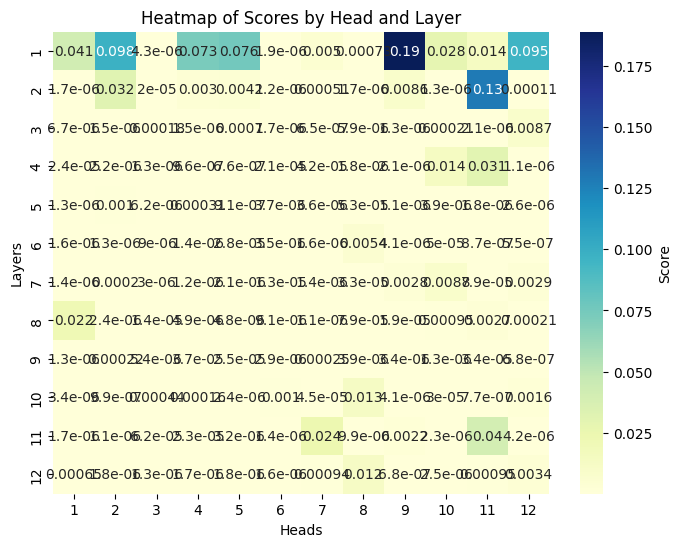

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df = pd.DataFrame(scores.reshape(12, 12), index=[i for i in range(1, 13)], columns=[i for i in range(1, 13)])
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Score'})
plt.title('Heatmap of Scores by Head and Layer')
plt.xlabel('Heads')
plt.ylabel('Layers')
plt.show()


- Tính tổng theo lớp, head với hệ số tìm được ở ma trận trên

In [5]:
# shape của 1 mask. 12 block, 12 head với 1 mask có shape là 14x14
masks = ours_heatmap[0]
masks.shape

torch.Size([12, 12, 1, 14, 14])

In [6]:
my_cam = 0
index = 0
for i in range(masks.shape[0]):
    for j in range(masks.shape[1]):
        mask = masks[i][j]
        my_cam += scores[index] * mask
        index += 1

my_cam = transforms.Resize((224, 224))(my_cam)
my_cam = (my_cam - my_cam.min())/(my_cam.max()-my_cam.min())
my_cam = my_cam.detach().cpu().numpy()
my_cam = np.transpose(my_cam, (1, 2, 0))   
# tensor_heatmap = heatmap
# heatmap = heatmap.detach().cpu().numpy()
# my_cam = np.transpose(my_cam, (1, 2, 0))
my_cam.shape

(224, 224, 1)

(-0.5, 223.5, 223.5, -0.5)

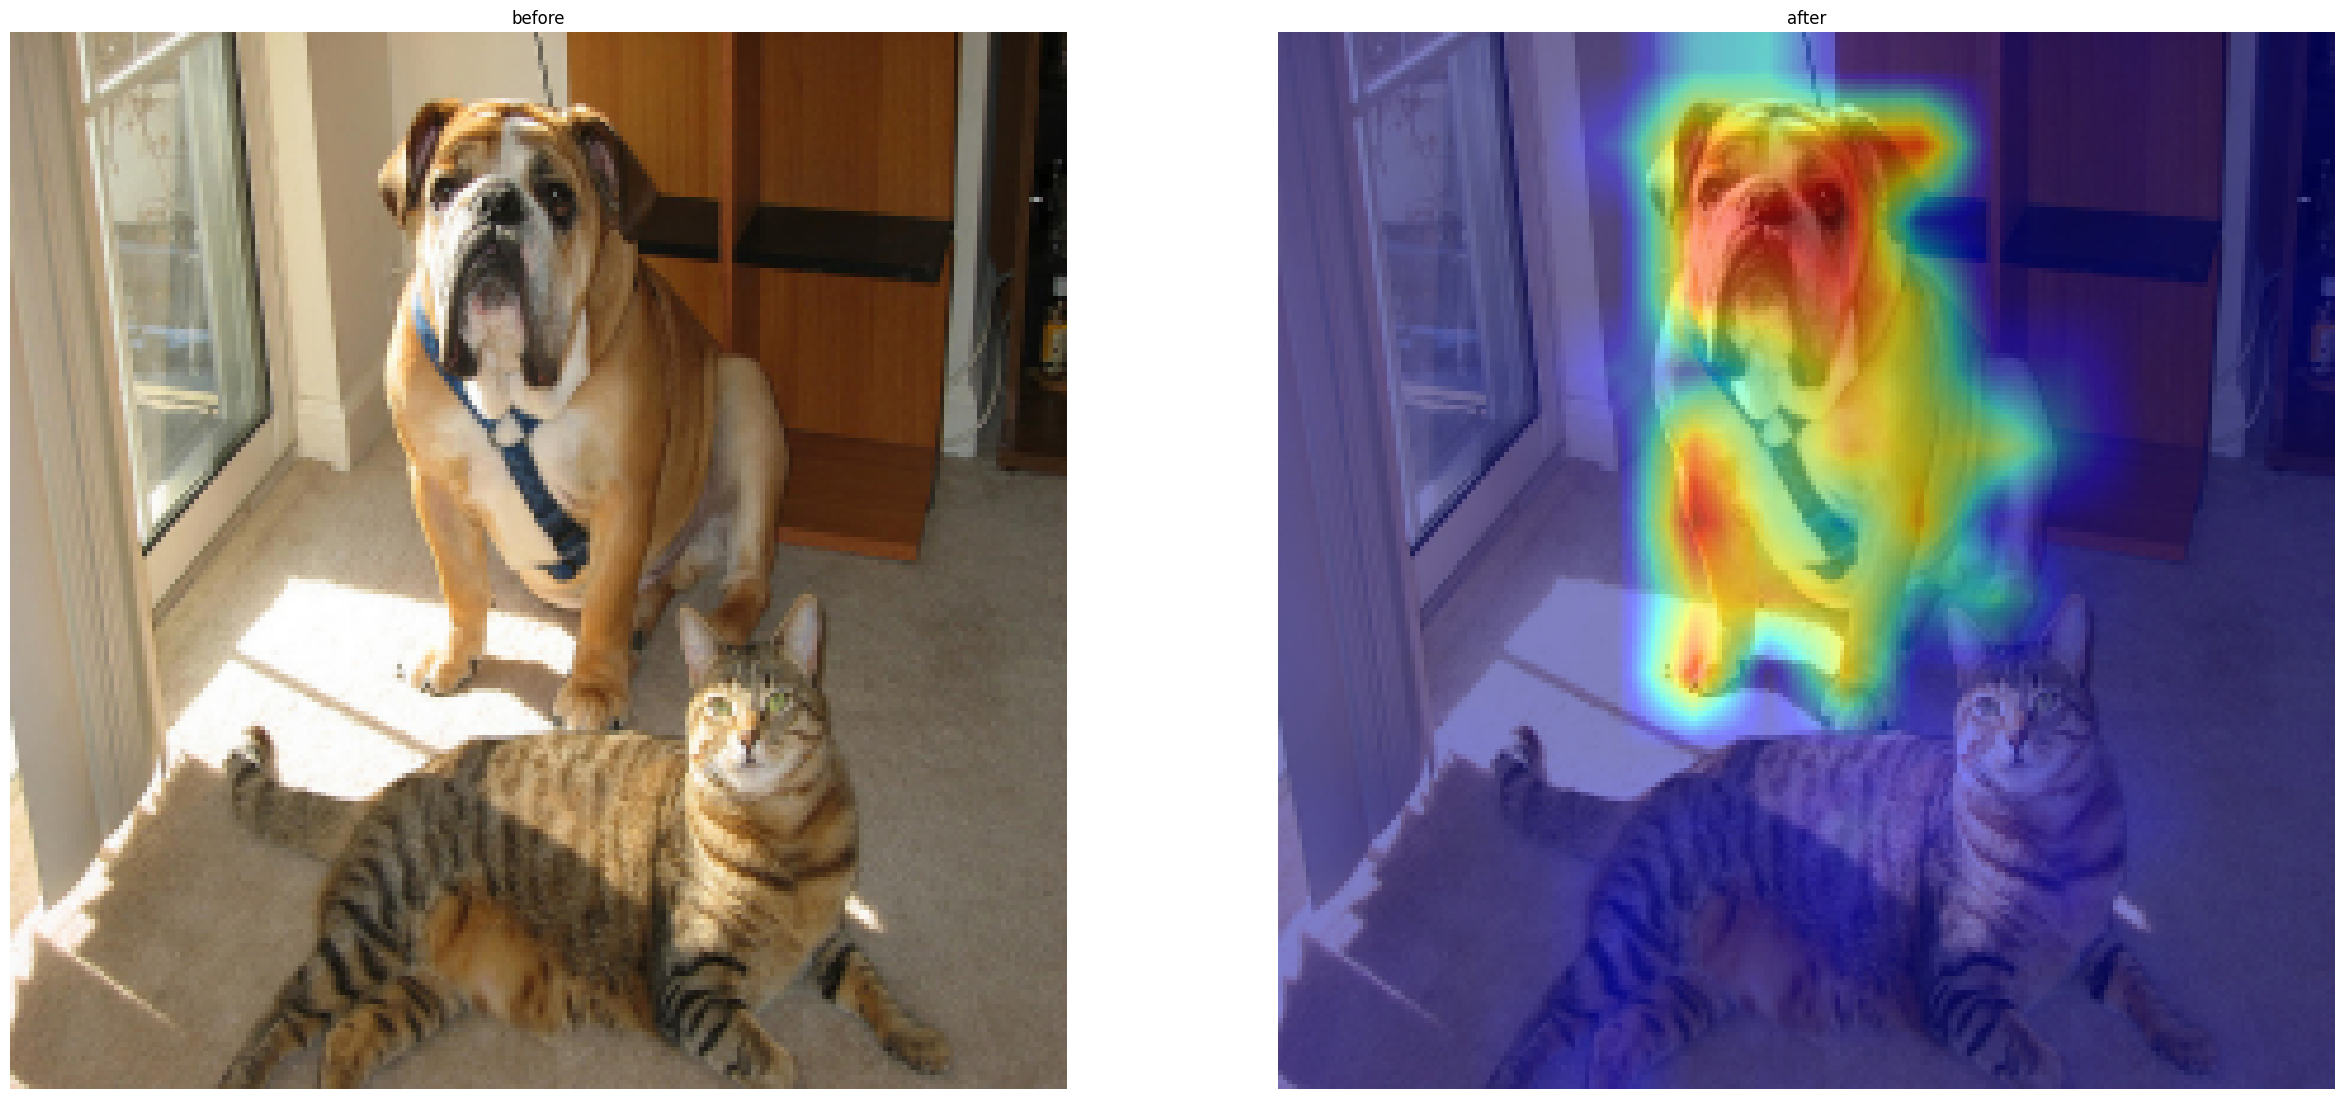

In [9]:
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)
image = unnormalize(image)
image = image.detach().cpu().numpy()[0]
image = np.transpose(image, (1, 2, 0))

fig, axs = plt.subplots(1,2, figsize=(30, 30))
axs[0].set_title('before')
axs[0].imshow(image)
axs[0].axis('off')
axs[1].set_title('after')
axs[1].imshow(image)
axs[1].imshow(my_cam, cmap='jet', alpha=0.5)
axs[1].axis('off')


In [7]:
heatmap.max()

1.0

In [2]:
from Methods.AGCAM.AGCAM import AGCAM

#Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/ILSVRC2012_val_00000125.jpeg"

# Open the input image and transform
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)

# Models and Methods
ours_model = ViT_Ours.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
ours_model.load_state_dict(state_dict, strict=True)
ours_model.eval()
ours_method = AGCAM(ours_model)

with torch.enable_grad():
    # Generate heatmap of our method
    prediction, ours_heatmap = ours_method.generate(image)
    ours_heatmap = transforms.Resize((224, 224))(ours_heatmap[0])
    ours_heatmap = (ours_heatmap - ours_heatmap.min())/(ours_heatmap.max()-ours_heatmap.min())
    ours_heatmap = ours_heatmap.detach().cpu().numpy()
    ours_heatmap = np.transpose(ours_heatmap, (1, 2, 0))

    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1,2, figsize=(15, 70))
    axs[0].set_title(classes[prediction.item()])
    axs[0].imshow(image)
    axs[0].axis('off')

    axs[1].set_title('Ours')
    axs[1].imshow(image)
    axs[1].imshow(ours_heatmap, cmap='jet', alpha=0.5)
    axs[1].axis('off')

torch.Size([12, 12, 1, 197])
torch.Size([1, 12, 12, 1, 196])
torch.Size([1, 12, 12, 1, 14, 14])


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [1, 14, 14] and output size of [224, 224]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

torch.Size([12, 12, 1, 197])
torch.Size([1, 12, 12, 1, 196])
torch.Size([1, 12, 1, 196])
torch.Size([1, 1, 196])
torch.Size([1, 1, 14, 14])


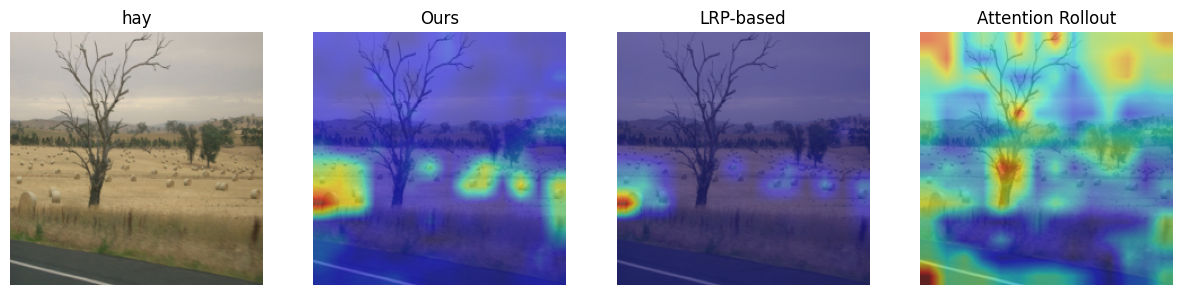

In [3]:


#Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/ILSVRC2012_val_00001372.jpeg"

image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)


with torch.enable_grad():
    # Generate heatmap of our method
    prediction, ours_heatmap = ours_method.generate(image)
    ours_heatmap = transforms.Resize((224, 224))(ours_heatmap[0])
    ours_heatmap = (ours_heatmap - ours_heatmap.min())/(ours_heatmap.max()-ours_heatmap.min())
    ours_heatmap = ours_heatmap.detach().cpu().numpy()
    ours_heatmap = np.transpose(ours_heatmap, (1, 2, 0))
    
    # Generate heatmap of LRP-based method
    _, lrp_heatmap = lrp_method.generate(image)
    lrp_heatmap = transforms.Resize((224, 224))(lrp_heatmap[0])
    lrp_heatmap = (lrp_heatmap - lrp_heatmap.min())/(lrp_heatmap.max()-lrp_heatmap.min())
    lrp_heatmap = lrp_heatmap.detach().cpu().numpy()
    lrp_heatmap = np.transpose(lrp_heatmap, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))

    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1,4, figsize=(15, 70))
    axs[0].set_title(classes[prediction.item()])
    axs[0].imshow(image)
    axs[0].axis('off')
    
    axs[1].set_title('Ours')
    axs[1].imshow(image)
    axs[1].imshow(ours_heatmap, cmap='jet', alpha=0.5)
    axs[1].axis('off')
    
    axs[2].set_title('LRP-based')
    axs[2].imshow(image)
    axs[2].imshow(lrp_heatmap, cmap='jet', alpha=0.5)
    axs[2].axis('off')

    axs[3].set_title('Attention Rollout')
    axs[3].imshow(image)
    axs[3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[3].axis('off')
    
    


torch.Size([12, 12, 1, 197])
torch.Size([1, 12, 12, 1, 196])
torch.Size([1, 12, 1, 196])
torch.Size([1, 1, 196])
torch.Size([1, 1, 14, 14])


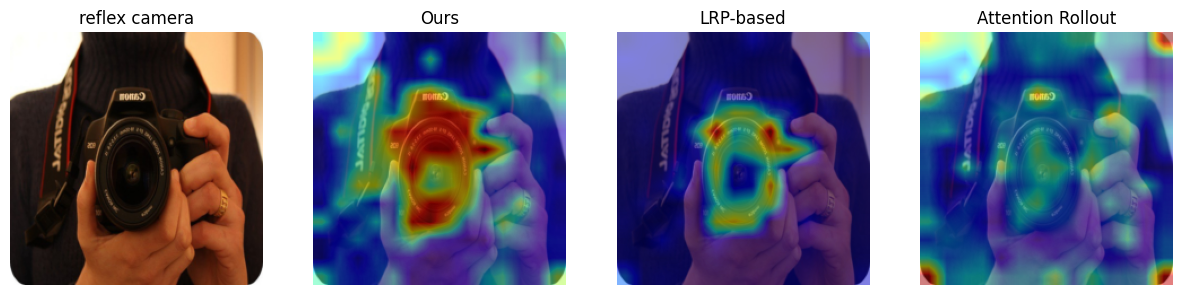

In [4]:


#Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/ILSVRC2012_val_00001854.jpeg"

image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)

    
   
    
    
with torch.enable_grad():
    # Generate heatmap of our method
    prediction, ours_heatmap = ours_method.generate(image)
    ours_heatmap = transforms.Resize((224, 224))(ours_heatmap[0])
    ours_heatmap = (ours_heatmap - ours_heatmap.min())/(ours_heatmap.max()-ours_heatmap.min())
    ours_heatmap = ours_heatmap.detach().cpu().numpy()
    ours_heatmap = np.transpose(ours_heatmap, (1, 2, 0))

    # Generate heatmap of LRP-based method
    _, lrp_heatmap = lrp_method.generate(image)
    lrp_heatmap = transforms.Resize((224, 224))(lrp_heatmap[0])
    lrp_heatmap = (lrp_heatmap - lrp_heatmap.min())/(lrp_heatmap.max()-lrp_heatmap.min())
    lrp_heatmap = lrp_heatmap.detach().cpu().numpy()
    lrp_heatmap = np.transpose(lrp_heatmap, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))

    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1,4, figsize=(15, 70))
    axs[0].set_title(classes[prediction.item()])
    axs[0].imshow(image)
    axs[0].axis('off')
    
    axs[1].set_title('Ours')
    axs[1].imshow(image)
    axs[1].imshow(ours_heatmap, cmap='jet', alpha=0.5)
    axs[1].axis('off')
    
    axs[2].set_title('LRP-based')
    axs[2].imshow(image)
    axs[2].imshow(lrp_heatmap, cmap='jet', alpha=0.5)
    axs[2].axis('off')

    axs[3].set_title('Attention Rollout')
    axs[3].imshow(image)
    axs[3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[3].axis('off')
    
    


### Class-specific Explanation

torch.Size([12, 12, 1, 197])
torch.Size([1, 12, 12, 1, 196])
torch.Size([1, 12, 1, 196])
torch.Size([1, 1, 196])
torch.Size([1, 1, 14, 14])
torch.Size([12, 12, 1, 197])
torch.Size([1, 12, 12, 1, 196])
torch.Size([1, 12, 1, 196])
torch.Size([1, 1, 196])
torch.Size([1, 1, 14, 14])


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\임새봄\\논문\\poster\\image1.png'

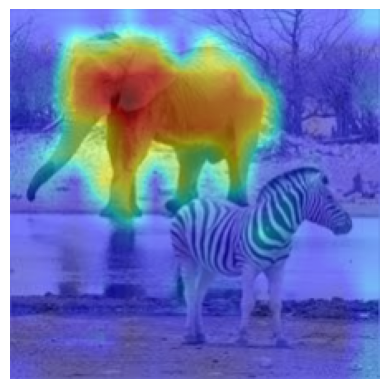

In [5]:
# Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/tusker_zebra.png"
# The class number for which the methods produce the heatmap
class1=101
class2=340
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)

    

with torch.enable_grad():
    # Generate heatmap of our method
    _, ours_1 = ours_method.generate(image, class1)
    ours_1 = transforms.Resize((224, 224))(ours_1[0])
    ours_1 = (ours_1 - ours_1.min())/(ours_1.max()-ours_1.min())
    ours_1 = ours_1.detach().cpu().numpy()
    ours_1 = np.transpose(ours_1, (1, 2, 0))
    _, ours_2 = ours_method.generate(image, class2)
    ours_2 = transforms.Resize((224, 224))(ours_2[0])
    ours_2 = (ours_2 - ours_2.min())/(ours_2.max()-ours_2.min())
    ours_2 = ours_2.detach().cpu().numpy()
    ours_2 = np.transpose(ours_2, (1, 2, 0))

    # Generate heatmap of LRP-based method
    _, lrp_1 = lrp_method.generate(image, class1)
    lrp_1 = transforms.Resize((224, 224))(lrp_1[0])
    lrp_1 = (lrp_1 - lrp_1.min())/(lrp_1.max()-lrp_1.min())
    lrp_1 = lrp_1.detach().cpu().numpy()
    lrp_1 = np.transpose(lrp_1, (1, 2, 0))
    _, lrp_2 = lrp_method.generate(image, class2)
    lrp_2 = transforms.Resize((224, 224))(lrp_2[0])
    lrp_2 = (lrp_2 - lrp_2.min())/(lrp_2.max()-lrp_2.min())
    lrp_2 = lrp_2.detach().cpu().numpy()
    lrp_2 = np.transpose(lrp_2, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    # Attention Rollout cannot produce a class-specific visualization.
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))
    
    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    plt.axis('off')
    plt.imshow(image)
    plt.imshow(ours_1, cmap='jet', alpha=0.5)
    plt.savefig("C:\\임새봄\\논문\\poster\\image1.png")
    plt.imshow(image)
    plt.imshow(ours_2, cmap='jet', alpha=0.5)
    plt.savefig("C:\\임새봄\\논문\\poster\\image2.png")



    fig, axs = plt.subplots(2,4, figsize=(15, 7))
    axs[0,0].text(0.5, 0.5, classes[class1], fontsize='x-large')
    axs[0,0].axis('off')

    axs[0,1].set_title('Ours')
    axs[0,1].imshow(image)
    axs[0,1].imshow(ours_1, cmap='jet', alpha=0.5)
    axs[0,1].axis('off')


    axs[0,2].set_title('LRP-based')
    axs[0,2].imshow(image)
    axs[0,2].imshow(lrp_1, cmap='jet', alpha=0.5)
    axs[0,2].axis('off')

    axs[0,3].set_title('Attention Rollout')
    axs[0,3].imshow(image)
    axs[0,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[0,3].axis('off')

    axs[1,0].text(0.5, 0.5, classes[class2], fontsize='x-large')
    axs[1,0].axis('off')

    axs[1,1].imshow(image)
    axs[1,1].imshow(ours_2, cmap='jet', alpha=0.5)
    axs[1,1].axis('off')

    axs[1,2].imshow(image)
    axs[1,2].imshow(lrp_2, cmap='jet', alpha=0.5)
    axs[1,2].axis('off')

    axs[1,3].imshow(image)
    axs[1,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[1,3].axis('off')

In [ ]:
# Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/catdog.png"
# The class number for which the methods produce the heatmap
class1=282
class2=243
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)
    

with torch.enable_grad():
    # Generate heatmap of our method
    _, ours_1 = ours_method.generate(image, class1)
    ours_1 = transforms.Resize((224, 224))(ours_1[0])
    ours_1 = (ours_1 - ours_1.min())/(ours_1.max()-ours_1.min())
    ours_1 = ours_1.detach().cpu().numpy()
    ours_1 = np.transpose(ours_1, (1, 2, 0))
    _, ours_2 = ours_method.generate(image, class2)
    ours_2 = transforms.Resize((224, 224))(ours_2[0])
    ours_2 = (ours_2 - ours_2.min())/(ours_2.max()-ours_2.min())
    ours_2 = ours_2.detach().cpu().numpy()
    ours_2 = np.transpose(ours_2, (1, 2, 0))

    # Generate heatmap of LRP-based method
    _, lrp_1 = lrp_method.generate(image, class1)
    lrp_1 = transforms.Resize((224, 224))(lrp_1[0])
    lrp_1 = (lrp_1 - lrp_1.min())/(lrp_1.max()-lrp_1.min())
    lrp_1 = lrp_1.detach().cpu().numpy()
    lrp_1 = np.transpose(lrp_1, (1, 2, 0))
    _, lrp_2 = lrp_method.generate(image, class2)
    lrp_2 = transforms.Resize((224, 224))(lrp_2[0])
    lrp_2 = (lrp_2 - lrp_2.min())/(lrp_2.max()-lrp_2.min())
    lrp_2 = lrp_2.detach().cpu().numpy()
    lrp_2 = np.transpose(lrp_2, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))
    
    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    
    fig, axs = plt.subplots(2,4, figsize=(15, 7))
    axs[0,0].text(0.5, 0.5, classes[class1], fontsize='x-large')
    axs[0,0].axis('off')

    axs[0,1].set_title('Ours')
    axs[0,1].imshow(image)
    axs[0,1].imshow(ours_1, cmap='jet', alpha=0.5)
    axs[0,1].axis('off')


    axs[0,2].set_title('LRP-based')
    axs[0,2].imshow(image)
    axs[0,2].imshow(lrp_1, cmap='jet', alpha=0.5)
    axs[0,2].axis('off')

    axs[0,3].set_title('Attention Rollout')
    axs[0,3].imshow(image)
    axs[0,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[0,3].axis('off')

    axs[1,0].text(0.5, 0.5, classes[class2], fontsize='x-large')
    axs[1,0].axis('off')

    axs[1,1].imshow(image)
    axs[1,1].imshow(ours_2, cmap='jet', alpha=0.5)
    axs[1,1].axis('off')

    axs[1,2].imshow(image)
    axs[1,2].imshow(lrp_2, cmap='jet', alpha=0.5)
    axs[1,2].axis('off')

    axs[1,3].imshow(image)
    axs[1,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[1,3].axis('off')

In [ ]:
# Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/dogbird.png"
# The class number for which the methods produce the heatmap
class1=87
class2=161
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)
  
    
with torch.enable_grad():
    # Generate heatmap of our methods
    _, ours_1 = ours_method.generate(image, class1)
    ours_1 = transforms.Resize((224, 224))(ours_1[0])
    ours_1 = (ours_1 - ours_1.min())/(ours_1.max()-ours_1.min())
    ours_1 = ours_1.detach().cpu().numpy()
    ours_1 = np.transpose(ours_1, (1, 2, 0))
    _, ours_2 = ours_method.generate(image, class2)
    ours_2 = transforms.Resize((224, 224))(ours_2[0])
    ours_2 = (ours_2 - ours_2.min())/(ours_2.max()-ours_2.min())
    ours_2 = ours_2.detach().cpu().numpy()
    ours_2 = np.transpose(ours_2, (1, 2, 0))

    # Generate heatmap of LRP-based method
    _, lrp_1 = lrp_method.generate(image, class1)
    lrp_1 = transforms.Resize((224, 224))(lrp_1[0])
    lrp_1 = (lrp_1 - lrp_1.min())/(lrp_1.max()-lrp_1.min())
    lrp_1 = lrp_1.detach().cpu().numpy()
    lrp_1 = np.transpose(lrp_1, (1, 2, 0))
    _, lrp_2 = lrp_method.generate(image, class2)
    lrp_2 = transforms.Resize((224, 224))(lrp_2[0])
    lrp_2 = (lrp_2 - lrp_2.min())/(lrp_2.max()-lrp_2.min())
    lrp_2 = lrp_2.detach().cpu().numpy()
    lrp_2 = np.transpose(lrp_2, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))
    
    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    
    fig, axs = plt.subplots(2,4, figsize=(15, 7))
    axs[0,0].text(0.5, 0.5, classes[class1].split(',')[0] + '\n' + classes[class1].split(',')[1]+'\n'+classes[class1].split(',')[2], )
    axs[0,0].axis('off')

    axs[0,1].set_title('Ours')
    axs[0,1].imshow(image)
    axs[0,1].imshow(ours_1, cmap='jet', alpha=0.5)
    axs[0,1].axis('off')


    axs[0,2].set_title('LRP-based')
    axs[0,2].imshow(image)
    axs[0,2].imshow(lrp_1, cmap='jet', alpha=0.5)
    axs[0,2].axis('off')

    axs[0,3].set_title('Attention Rollout')
    axs[0,3].imshow(image)
    axs[0,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[0,3].axis('off')

    axs[1,0].text(0.5, 0.5, classes[class2], )
    axs[1,0].axis('off')

    axs[1,1].imshow(image)
    axs[1,1].imshow(ours_2, cmap='jet', alpha=0.5)
    axs[1,1].axis('off')

    axs[1,2].imshow(image)
    axs[1,2].imshow(lrp_2, cmap='jet', alpha=0.5)
    axs[1,2].axis('off')

    axs[1,3].imshow(image)
    axs[1,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[1,3].axis('off')